## Loading imports

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import glob
from matplotlib import pyplot as plt
import cv2
from skimage.util import random_noise
import skimage
import torch
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import Dataset
import config

## Setting data to fixed lengh

In [4]:
path= r"C:\Users\nedwa\Documents\GitHub\Gan-Image-Transformer/Data/Unmodifed"

In [8]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob(path+'/*.jpg'): 
    im=Image.open(filename)
    im = im.resize((400, 400))

    image_list.append(im)
for filename in glob.glob(path+'/*.png'):
    im=Image.open(filename)
    im = im.resize((400, 400))
    image_list.append(im)

In [9]:
NP_Images_Orginal=[]
for img in image_list:
    pix = np.array(img)
    NP_Images_Orginal.append(pix)

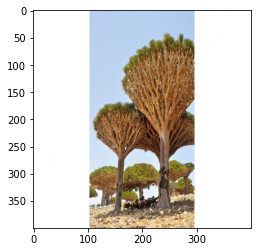

In [10]:
plt.imshow(NP_Images_Orginal[1])

## Adding Noise through gaussian process

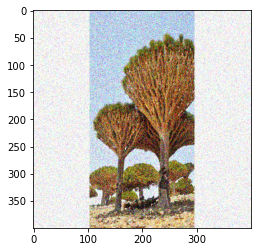

In [11]:
noisy = skimage.util.random_noise(NP_Images_Orginal[1], mode='gaussian', var=0.02)
plt.imshow(noisy)

In [12]:
NP_Images_Noisy=[]
for img in NP_Images_Orginal:
    Noisy_Image = skimage.util.random_noise(img, mode='gaussian', var=0.02)
    NP_Images_Noisy.append(Noisy_Image)

    

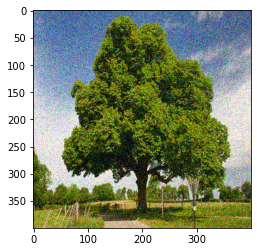

In [13]:
plt.imshow(NP_Images_Noisy[5])

In [14]:
print(len(NP_Images_Noisy))
print(len(NP_Images_Orginal))

122
122


Note the input will be Noisy images and the output will be the non noisy images

## Creating DataFrame

In [15]:
df = pd.DataFrame(columns = ['Input', 'Output'])
for i in range (len(NP_Images_Orginal)):
    df = df.append({'Input': NP_Images_Noisy[i],'Output':NP_Images_Orginal[i] }, ignore_index=True)


    


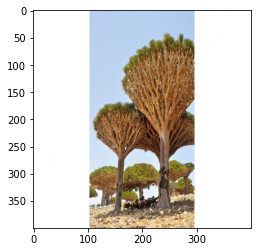

In [16]:
c=df.iloc[1]
plt.imshow(c[1])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Input   122 non-null    object
 1   Output  122 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


## Pytorch Dataset Based of pix2pix paper

## Pytorch Dataset Object X=noisy image Y=Orginal image

In [22]:
class Treeset(Dataset):
    df = pd.DataFrame(columns = ['Input', 'Output'])
    def __init__(self,Data):
        self.df=Data
    
    def __len__(self):
        len(df)
    def __getitem__(self,item):
        x=df.iloc[item][0]
        y=df.iloc[item][1]

        return x, y

        
    

In [23]:
Set=Treeset(df)

In [21]:
x,y=Set[1]

AttributeError: module 'config' has no attribute 'both_transform'

## Example input of Batch size 1 

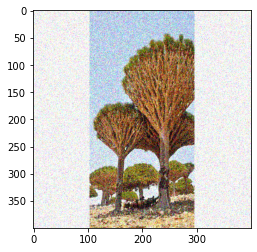

In [66]:
plt.imshow(x.data)

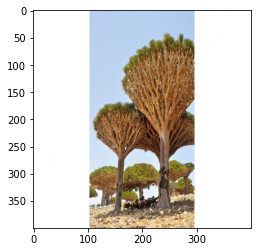

In [67]:
img_y=y.data.tolist()
plt.imshow(np.array(img_y,np.int32))

## Creation of Discremator Model

In [18]:
class CN(nn.Module):
    def __init__(self, in_c, o_ch, stride):
        super(CN, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_c, o_ch, 4, stride, 1, bias=False, padding_mode="reflect"),
            torch.nn.BatchNorm2d(o_ch),
            torch.nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        return self.conv(x)


class Discriminator(torch.nn.Module):
    def __init__(self, in_c=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_c * 2,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            torch.nn.LeakyReLU(0.2),
        )

        layers = []
        in_c = features[0]
        for feature in features[1:]:
            layers.append(
                CN(in_c, feature, stride=1 if feature == features[-1] else 2)
            )
            in_c = feature

        layers.append(
            torch.nn.Conv2d(
                in_c, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )

        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


In [19]:
x = torch.randn((1, 3, 256, 256))
y = torch.randn((1, 3, 256, 256))
model = Discriminator(in_c=3)#R
preds = model(x, y)
print(model)
print(preds.shape)


Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CN(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CN(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CN(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1

### The expected shape does match 
## Creation of Generator

In [24]:
class Gen(nn.Module):
    def __init__(self,in_c,out_c,down=True,act="relu",use_dropout=False):
        super().__init__()
        self.conv==nn.Sequential(
            nn.Conv2d(in_c,out_c,4,2,1,bias=False,padding_mode='reflect')
            if down:
            
            else:
                nn.ConvTranspose2d(in_c,out_c,4,2,1,bias='False'),
                nn.BatchNorm2d(out_channels),
                nn.Relu() if act ='relu' else nn.LeakyRelu(.2),
        def forward(self, x):
            x=self.conv(x)
        )